# Scikit-Learn & Regression

In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'Bitstream Vera Sans'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [2]:
states_abbrev_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}
abbrev_states_dict = {v: k for k, v in states_abbrev_dict.items()}

##First, a bit about scikit-learn

The structure of scikit-learn:

Some of the following text is taken from the scikit-learn API paper: http://arxiv.org/pdf/1309.0238v1.pdf

>All objects within scikit-learn share a uniform common basic API consisting of three complementary interfaces: an estimator interface for building and ﬁtting models, a predictor interface for making predictions and a transformer interface for converting data.

>The estimator interface is at the core of the library. It deﬁnes instantiation mechanisms of objects and exposes a ***fit*** method for learning a model from training data. All supervised and unsupervised learning algorithms (e.g., for classiﬁcation, regression or clustering) are oﬀered as objects implementing this interface. Machine learning tasks like feature extraction, feature selection or
dimensionality reduction are also provided as estimators.

An example along these lines:
```python
clf = LinearRegression()
clf.fit(X_train, y_train)
```

If one changes classifiers, say, to a Random Forest classifier, one would simply replace `LogisticRegression()` in the snippet above by `RandomForestClassifier()`.

>The **predictor** interface extends the notion of an estimator by adding a predict method that takes an array `X_test` and produces predictions for `X_test`, based on the learned parameters of the estimator. In the case of supervised learning estimators, this method typically returns the predicted labels or values computed by the model. Some unsupervised learning estimators may also implement the predict interface, such as k-means, where the predicted values are the cluster labels.

```python
clf.predict(X_test)
```

### Fitting

>Since it is common to modify or ﬁlter data before feeding it to a learning algorithm, some estimators in the library implement a **transformer** interface which deﬁnes a transform method. It takes as input some new data `X_test` and yields
as output a transformed version of `X_test`. Preprocessing, feature selection,
feature extraction and dimensionality reduction algorithms are all provided as
transformers within the library.

This is usually done via the `fit_transform` method. For example, to do a PCA:
```python
pca = RandomizedPCA(n_components=2)
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)
```

The training set here is "fit" to find the PC components, and then transformed. Since `pca.fit()` by itself changes the `pca` object, if we want to transform other data using the same transformation we simply call `transform` subsequently.

### Meta-estimator

Finally, for now, there is the concept of a meta-estimator, which behaves quite similarly to standard estimators, but allows us to wrap, for example, cross-validation, or methods that build and combine simpler models or schemes. For example:
```python
from sklearn.multiclass import OneVsOneClassifier
clf=OneVsOneClassifier(LogisticRegression())
```

>In scikit-learn, model selection is supported in two distinct meta-estimators, `GridSearchCV` and `RandomizedSearchCV`. They take as input an estimator (basic or composite), whose hyper-parameters must be optimized, and a set of hyperparameter settings to search through.

We shall use this latter functionality soon.

From Jake Vanderplas' PyCon 2014 tutorial [Representation of Data for Machine Learning](http://nbviewer.ipython.org/github/jakevdp/sklearn_pycon2014/blob/master/notebooks/02_data_representation.ipynb):

>Most machine learning algorithms implemented in scikit-learn expect data to be stored in a **two-dimensional array** or **matrix**. The arrays can be either numpy arrays, or in some cases scipy.sparse matrices. The size of the array is expected to be `[n_samples, n_features]`

To get a grip on how to do machine learning with scikit-learn, it is worth working through the entire set of notebooks at:
[sklearn_pycon2014](https://github.com/jakevdp/sklearn_pycon2014). These go relatively fast and are fun to read.

# PART 1: Linear Regression.

We'll see an example of the concepts mentioned above by considering a linear regression problem. Let us load the census data set.

In [3]:
census_data = pd.read_csv("../data/census_demographics.csv")
census_data.head()

,state,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
0,ALABAMA,26.5,4.0,66.8,81.4,21.7,22984,42081,94.4,3001712.500,672383.600,0.140,0.625
1,ALASKA,3.6,5.8,63.7,90.7,27.0,30726,66521,1.2,475548.444,58540.158,0.081,0.658
2,ARIZONA,4.5,30.1,57.4,85.0,26.3,25680,50448,56.3,3934880.535,920515.710,0.142,0.607
3,ARKANSAS,15.6,6.6,74.2,81.9,19.1,21274,39267,56.0,1798043.148,428944.934,0.146,0.612
4,CALIFORNIA,6.6,38.1,39.7,80.7,30.1,29188,60883,239.1,24009747.944,4409953.704,0.117,0.637


Clean the data set, and have it indexed by the state abbrev.

In [4]:
def capitalize(s):
    s = s.title()
    s = s.replace("Of", "of")
    return s
census_data["State"] = census_data.state.map(capitalize)
del census_data["state"]
census_data['State']=census_data['State'].replace(abbrev_states_dict)
census_data.set_index("State", inplace=True)
census_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
State,,,,,,,,,,,,
AL,26.5,4.0,66.8,81.4,21.7,22984,42081,94.4,3001712.500,672383.600,0.140,0.625
AK,3.6,5.8,63.7,90.7,27.0,30726,66521,1.2,475548.444,58540.158,0.081,0.658
AZ,4.5,30.1,57.4,85.0,26.3,25680,50448,56.3,3934880.535,920515.710,0.142,0.607
AR,15.6,6.6,74.2,81.9,19.1,21274,39267,56.0,1798043.148,428944.934,0.146,0.612
CA,6.6,38.1,39.7,80.7,30.1,29188,60883,239.1,24009747.944,4409953.704,0.117,0.637


Use a SPLOM to visualize the columns in the `smaller_frame` of this dataset. *Hint*: in Panda's the SPLOM is a one-liner.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1546ffe10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff134ce7250>]], dtype=object)

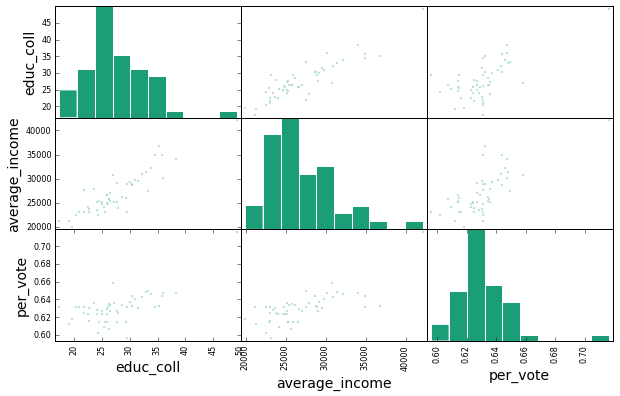

In [5]:
smaller_frame=census_data[['educ_coll', 'average_income', 'per_vote']]
from pandas.tools.plotting import scatter_matrix

#your code here

pd.scatter_matrix(smaller_frame)


Notice how `average_income` seems to have a strong correlation with `educ_coll`. Lets try and regress the former against the latter. One might expect that the average income is higher in states which have "better" education systems and send more students to college. Confirm our intuition by seeing the co-relations. *Hint*: Pandas also lets you do computations on data frames.

In [7]:
#your code here
Y = census_data.educ_coll
X = census_data.average_income
Y.cov(X)


21817.874352941177

We carry out the regression, first standardizing our variables. This is strictly not necessary, but we are doing it as we wish to play around with other methods. Since `scikit-learn` wants a `n_sample` rows times `n_features` matrix, we need to reshape the `x` variable. We store both an `_vec` variable, which is easier to plot with, as well as the reshaped variable. 

In [8]:
from sklearn.linear_model import LinearRegression
X_HD=smaller_frame[['educ_coll', 'average_income']].values
X_HDn=(X_HD - X_HD.mean(axis=0))/X_HD.std(axis=0)
educ_coll_std_vec=X_HDn[:,0]
educ_coll_std=educ_coll_std_vec.reshape(-1,1)
average_income_std_vec=X_HDn[:,1]
average_income_std=average_income_std_vec.reshape(-1,1)

Now split the data into a training set (`X_train`, `Y_train`) and a testing set (`X_test`, `Y_test`). By default, 25% of the data is reserved for testing. This is the first of multiple ways that we will see to do this.

In [9]:
from sklearn.cross_validation import train_test_split

#your code here
X_train, X_test, y_train, y_test = train_test_split(educ_coll_std,average_income_std, test_size =0.25)

We use the training set for the fit, and find what our predictions ought to be on both the training and test set.

In [10]:
clf1 = LinearRegression()
clf1.fit(X_train, y_train)
predicted_train = clf1.predict(X_train)
predicted_test = clf1.predict(X_test)
trains=X_train.reshape(1,-1).flatten()
tests=X_test.reshape(1,-1).flatten()
print clf1.coef_, clf1.intercept_

[[ 0.86608599]] [-0.09051016]


We plot the scatter against the fit for both training and test data.

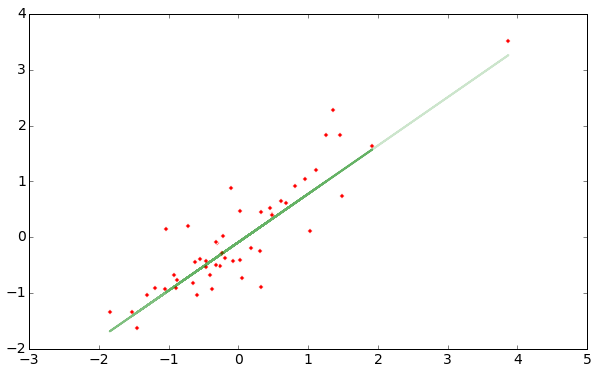

In [11]:
plt.scatter(educ_coll_std_vec, average_income_std_vec,c='r')
plt.plot(trains, predicted_train, c='g', alpha=0.5)
plt.plot(tests, predicted_test, c='g', alpha=0.2)

We then look at the residuals, again on both sets.

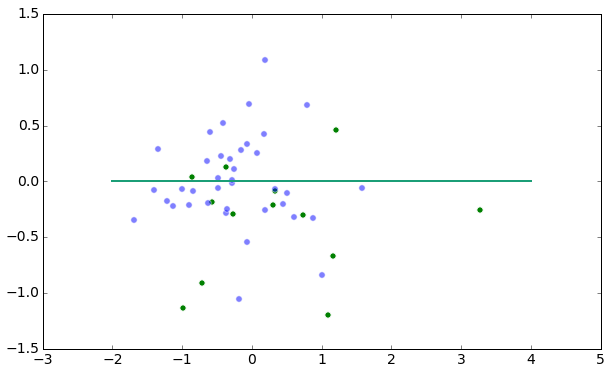

In [14]:
plt.scatter(predicted_test, predicted_test- y_test, c='g', s=40)
plt.scatter(predicted_train, predicted_train- y_train, c='b', s=40, alpha=0.5)
plt.plot([0.-2,4],[0,0])

Ask scikit-learn to spit out the $R^2$ via the `score` method for both training and test data. If you'd like R-style detailed information about your regression, use `statsmodels` instead.

In [34]:
# your code here
import sklearn.metrics  as skm

//print skm.statsmodels(trains, predicted_train)  
print skm.r2_score(tests, predicted_test)  

SyntaxError: invalid syntax (<ipython-input-34-06d5f5e39e33>, line 4)

# Part 2: Logistic Regression

From http://www.edwardtufte.com/tufte/ebooks, in "Visual and Statistical Thinking: Displays of Evidence for Making Decisions"

>On January 28, 1986, the space shuttle Challenger exploded and seven astronauts died because two rubber O-rings leaked. These rings had lost their resiliency because the shuttle was launched on a very cold day. Ambient temperatures were in the low 30s and the O-rings themselves were much colder, less than 20F.

>One day before the flight, the predicted temperature for the launch was 26F to 29F. Concerned that the rings would not seal at such a cold temperature, the engineers who designed the rocket opposed launching Challenger the next day.

But they did not make their case persuasively, and were over-ruled by NASA.

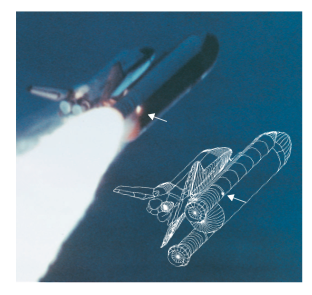

In [16]:
from IPython.display import Image as Im
from IPython.display import display
Im('../data/shuttle.png')

The image above shows the leak, where the O-ring failed.

We have here data on previous failures of the O-rings at various temperatures.

In [17]:
data=np.array([[float(j) for j in e.strip().split()] for e in open("../data/chall.txt")])
data

array([[ 66.,   0.],
       [ 70.,   1.],
       [ 69.,   0.],
       [ 68.,   0.],
       [ 67.,   0.],
       [ 72.,   0.],
       [ 73.,   0.],
       [ 70.,   0.],
       [ 57.,   1.],
       [ 63.,   1.],
       [ 70.,   1.],
       [ 78.,   0.],
       [ 67.,   0.],
       [ 53.,   1.],
       [ 67.,   0.],
       [ 75.,   0.],
       [ 70.,   0.],
       [ 81.,   0.],
       [ 76.,   0.],
       [ 79.,   0.],
       [ 75.,   1.],
       [ 76.,   0.],
       [ 58.,   1.]])

Lets plot this data:

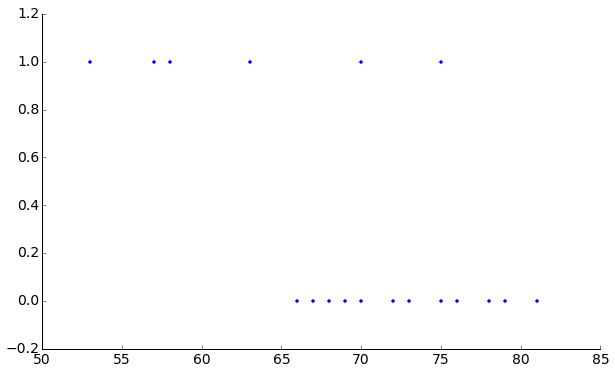

In [18]:
temps, pfail = data[:,0], data[:,1]
plt.scatter(temps, pfail)
axes=plt.gca()
axes.grid(False)
remove_border(axes)

1 represents failure. This graph has a classic sigmoid shape, so one might expect logistic regression to work. Furthermore, we do want to find the probability of failure and make predictions from there.

Logistic regression is carried out in the same way as linear. However, there is the "pesky" matter of setting the regularization co-efficient `C`. We havent still covered this in class, so what we do today is just a preview, but its nonetheless important to see.

The default `C` in sklearn is 1.The meaning of `C` is: the larger the `C`, the lesser the regularization. The smaller the `C` the higher the regularization.

What does regularization do? Larger regularizations penalize the values of regression coefficients. Smaller ones let the co-efficients range widely. Thus, larger `C` let the regression coefficients range widely. Scikit-learn bakes in two penalties: a l2 penalty which penalizes the sum of the squares of the coefficients, and a l1 penalty which penalizes the sum of the absolute values.

The reason for doing this is that is there are many co-variates we use for our prediction: we want to make sure we can get away with the simplest model that describes our data, even if that might increase the bias side of the bias-variance tradeoff a bit.

Remember here, though, that we have just two co-efficents: an intercept, and the outside temperature. So we do not expect to need regularization much. Indeed lets set `C=1000`.

In [19]:
from sklearn.linear_model import LogisticRegression
reg=1000.
clf4 = LogisticRegression(C=reg)
clf4.fit(temps.reshape(-1,1), pfail)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

Lets make predictions, get the associated probabilities, and plot them. We create a new grid of temperatures to evaluate our predictions at. Note that we do not do a test/train split: we have only 23 data points, but need to shut down the launch if there is any doubt. One wishes... :-(

In [20]:
tempsnew=np.linspace(20., 90., 15)
probs = clf4.predict_proba(tempsnew.reshape(-1,1))[:, 1]
predicts = clf4.predict(tempsnew.reshape(-1,1))

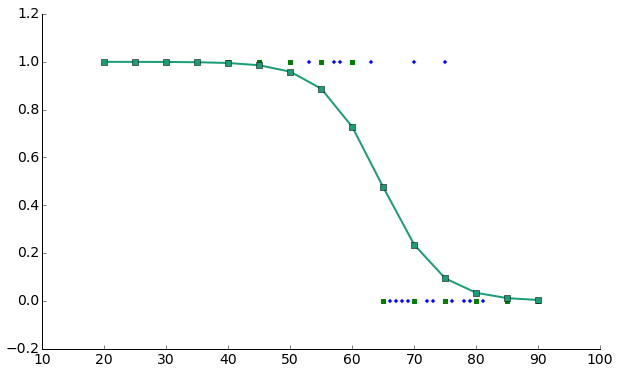

In [21]:
plt.scatter(temps, pfail)
axes=plt.gca()
axes.grid(False)
remove_border(axes)
plt.plot(tempsnew, probs, marker='s')
plt.scatter(tempsnew, predicts, marker='s', color="green")

We use pandas `crosstab` to write a table of prediction vs failure on the "training" set. As one might expect, the mislabellings come at the higher temperatures.

In [22]:
pd.crosstab(pfail, clf4.predict(temps.reshape(-1,1)), rownames=["Actual"], colnames=["Predicted"])

Predicted,0.0,1.0
Actual,,
0,16,0
1,3,4


Carry out a Logistic Regression with scikit-learn's default value for `C`. Make a plot similar to the scatterplot above, and carry out the cross-tabulation. What happens?

In [ ]:
#your code here


In [ ]:
#your code here


## Logistic Regression with cross-validation

We now actually go ahead and to the train/test split. Not once but multiple times, on a grid search, for different values of `C`. For each `C`, we:

1. create `n_folds` folds. Since the data size is 23 here, and we have 5 folds, we roughly split the data into 5 folds of 4-5 values each, randomly. 
2. We then train on 4 of these folds, test on the 5th
3. We average the results of all such combinations
4. We move on to the next value of `C`, and find the optimal value that minimizes mean square error.
5. We finally use that value to make the final fit.

Notice the structure of the `GridSearchCV` estimator in `cv_optimize`.

In [ ]:
from sklearn.linear_model import LogisticRegression
def fit_logistic(X_train, y_train, reg=0.0001, penalty="l2"):
    clf = LogisticRegression(C=reg, penalty=penalty)
    clf.fit(X_train, y_train)
    return clf

from sklearn.grid_search import GridSearchCV

def cv_optimize(X_train, y_train, paramslist, penalty="l2", n_folds=10):
    clf = LogisticRegression(penalty=penalty)
    parameters = {"C": paramslist}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X_train, y_train)
    return gs.best_params_, gs.best_score_

def cv_and_fit(X_train, y_train, paramslist, penalty="l2", n_folds=5):
    bp, bs = cv_optimize(X_train, y_train, paramslist, penalty=penalty, n_folds=n_folds)
    print "BP,BS", bp, bs
    clf = fit_logistic(X_train, y_train, penalty=penalty, reg=bp['C'])
    return clf

In [ ]:
clf=cv_and_fit(temps.reshape(-1,1), pfail, np.logspace(-4, 3, num=100))

In [ ]:
pd.crosstab(pfail, clf.predict(temps.reshape(-1,1)), rownames=["Actual"], colnames=["Predicted"])

We plot our results, this time also marking in red the predictions on the "training" set.

In [ ]:
plt.scatter(temps, pfail, s=40)
axes=plt.gca()
axes.grid(False)
remove_border(axes)
probs=clf.predict_proba(tempsnew.reshape(-1,1))[:,1]
predicts=clf.predict(tempsnew.reshape(-1,1))
plt.plot(tempsnew, probs, marker='s')
plt.scatter(tempsnew, predicts, marker='D', color="green", s=80, alpha=0.4)
train_probs=clf.predict_proba(temps.reshape(-1,1))[:,1]
plt.scatter(temps, train_probs, marker='s', c='r', alpha=0.5, s=40)
train_predicts=clf.predict(temps.reshape(-1,1))
plt.scatter(temps, train_predicts, marker='s', c='r', alpha=0.2, s=80)

The failures in prediction are, exactly where you might have expected them to be, as before.

In [ ]:
zip(temps,pfail, clf.predict(temps.reshape(-1,1)))

We note that the true story was even worse than our data made it out to be! We did not take the severity of the incidents into account. How could we have incorporated this severity into our analysis? (these images are taken from Tufte's booklet).

![](../data/chall-table.png)

![](../data/chall-damage.png)